# Bregman gradient methods for tomographic reconstruction problems

We present the experiments on a practical use case of Poisson inverse problems: tomographic reconstruction.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from skimage.transform import radon, rescale

In [3]:
from skimage.data import shepp_logan_phantom

In [4]:
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 13
plt.rcParams["lines.linewidth"] = 3

## 1. CT specific functions

In [5]:
def adjoint_radon(radon_image, theta):
    """Adjoint of radon transform. Code adapted from the implementation in skimage.transform
    
    https://github.com/scikit-image/scikit-image/blob/master/skimage/transform/radon_transform.py#L184-L314
    
    """
    
    img_shape = radon_image.shape[0]
    output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))
    
    reconstructed = np.zeros((output_size, output_size))
    radius = output_size // 2
    
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_image.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        reconstructed += np.interp(t, xp = x, fp = col, left = 0, right = 0)
    
    return reconstructed

In [6]:
def D_KL(x,y):
    return np.sum(rel_entr(x,y) - x + y)

In [7]:
class CT_PoissonObj():
    """Defines the Poisson inverse problem objective
        f(x) = D_KL(b + eps, A * x + eps)
        for the tomography reconstruction problem
    """
    
    def __init__(self, b, theta, eps = 1e-15):
        """b: array with the tomography image
        Theta: array or int
            reconstruction angles if array. If int
            the angles are evenly spaced in [0,180]
        eps: lowerbound safeguard on b
            """
        
        self.b = b
        self.n = b.size
        self.eps = eps
        
        if isinstance(theta, int):
            self.theta = np.linspace(0., 180., theta, endpoint=False)
        elif isinstance(theta, np.ndarray):
            self.theta = theta
            
        self.n_theta = self.theta.size
        assert self.n_theta == b.shape[1], 'number of projection angles does not match'
    
    def mult_A(self, x, batch = "full"):
        """Performs the forward operation Ax"""
        
        if batch == "full":
            theta_batch = self.theta
        else:
            theta_batch = self.theta[batch]
        
        return radon(x, theta_batch, circle = False)
    
    def mult_AT(self, y, batch = "full"):
        """Performs the adjoint operation A.T y"""
        
        if batch == "full":
            theta_batch = self.theta
        else:
            theta_batch = self.theta[batch]
        
        return adjoint_radon(y, theta_batch)
    
    def __call__(self, x, grad = True, obj=True, Ax = None, batch = 'full'):
        """returns objective value and gradient if grad = true
        can be set to stochasti if batch is set to a set of indices"""
        
        if batch == 'full':
            batch_size = self.n_theta
            b_batch = self.b
        else:
            batch_size = len(batch)
            b_batch = self.b[:,batch]
            
        if Ax is None:
            Ax = self.mult_A(x, batch)

        if obj:
            obj_val = D_KL(b_batch + self.eps, Ax + self.eps) / batch_size
        else:
            obj_val = 0.
            
        if grad:
            grad_val = self.mult_AT(1 - (b_batch + self.eps) / (Ax + self.eps), batch) / batch_size
            
            return obj_val, grad_val
        else:
            return obj_val

## 2. Algorithms

In [8]:
def MU(obj, x0, max_epochs = 100):
    """Standard baseline algorithm for Poisson problems.
    Multiplicative update, a.k.a. Lucy-Richardson or Expectation-minimization algorithm"""
    
    x = np.copy(x0)
    F_vals = []
    grad_evals = []
        
    for i in range(max_epochs):
        Ax = obj.mult_A(x)
        
        f_val = obj(x, grad = False, Ax = Ax)
        
        AT1 = obj.mult_AT(np.ones_like(b))
        x = x * obj.mult_AT( (b + obj.eps) / (Ax + obj.eps)) / AT1
        
        F_vals.append(f_val)
        grad_evals.append(i+1)
    
    return x, F_vals, grad_evals

In [9]:
class LogKernel():
    """Log-barrier mirror kernel
        h(x) = - sum_i log(x_i) + 0.5 * sigma |x|^2
    """
    
    def __init__(self, sigma = 0., eps = 1e-10):
        self.sigma = sigma
        self.eps = eps
    
    def bregman_step(self, x, g, step = 1.):
        
        if self.sigma == 0.:
            denom = step * (x + self.eps) * g + 1

            if denom.min() <= 0.:
                print(denom.min())
                np.where(denom < 0, 0)
                raise Error("Bregman gradient step is outside of nonnegative orthant. \
                            Step size might be too large")
            
            return (x + self.eps) / denom - self.eps
        else:
            q = - 1. / x + self.sigma * x - step * g
            delta = (q ** 2) + 4 * self.sigma
            return (q + np.sqrt(delta)) / (2 * self.sigma)

In [10]:
def BGD(obj, kernel, x0, step = 1., max_epochs = 100):
    """vanilla bregman gradient descent with fixed step size"""
    x = np.copy(x0)
    F_vals = []
    grad_evals = []
    
    for i in range(max_epochs):
        f_val, f_grad = obj(x)
        x = kernel.bregman_step(x, f_grad, step)
        
        F_vals.append(f_val)
        grad_evals.append(i+1)
        
    return x, F_vals, grad_evals


In [11]:
def B_SGD(obj, kernel, x0, step = 1., max_epochs = 100):
    """Bregman SGD with fixed step size"""
    
    x = np.copy(x0)
    F_vals = []
    grad_evals = []
    
    n = obj.n_theta
    
    idces = np.arange(n)
    np.random.shuffle(idces)
    
    for i in range(max_epochs):
        f_val = 0.
        
        for j in range(n):  
            fj_val, fj_grad = obj(x, batch = [idces[j]])
            x = kernel.bregman_step(x, fj_grad, step)
            
            f_val += fj_val
            
        F_vals.append(f_val / n)
        grad_evals.append(i+1)
        
    return x, F_vals, grad_evals

In [13]:
def B_SAGA(obj, kernel, x0, step = 1., max_epochs = 1000):
    """Bregman SAGA algorithm"""
    
    x = np.copy(x0)
    F_vals = []
    grad_evals = []
    
    n, d1, d2 = obj.n_theta, x0.shape[0], x0.shape[1]
    grads_phi = np.zeros((n, d1, d2))

    grad_sum = np.sum(grads_phi, 0)
    
    idces = np.arange(n)
    
    for i in range(max_epochs):
        f_val = 0.
            
        np.random.shuffle(idces)
        
        for j in idces:
            fj_val, fj_grad = obj(x, batch = [j])
            gj = fj_grad - grads_phi[j] + 1 / n * grad_sum
            
            x = kernel.bregman_step(x, gj, step)
            
            grad_sum += fj_grad - grads_phi[j]
            grads_phi[j] = fj_grad
            
        f_val = obj(x, grad=False)
        F_vals.append(f_val)
        grad_evals.append(i+2)
        
    return x, F_vals, grad_evals

## 3. Testing

In [14]:
n_theta = 360
theta = np.linspace(0., 180., n_theta, endpoint=False)

img = shepp_logan_phantom()
img = rescale(img, scale=0.25, mode='reflect', multichannel=False)

offset = 0.

nx = img.shape[0]

sinogram = radon(np.copy(img), theta=theta, circle=False)
ny = sinogram.shape[0]

# add noise
photon_count = 1e1
b = np.random.poisson(photon_count * sinogram, size = (ny, n_theta))

/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [53]:
img.shape

(100, 100)

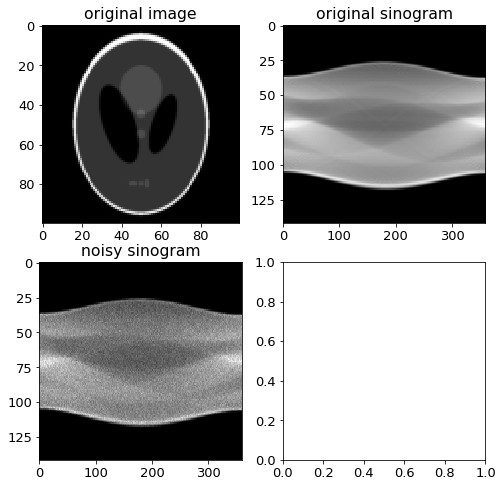

In [18]:
fig, axes = plt.subplots(2, 2, figsize = (8,8))

axes[0,0].imshow(img,'gray')
axes[0,0].set_title('original image')
axes[0,1].imshow(sinogram, 'gray', aspect = 'auto')
axes[0,1].set_title('original sinogram')
axes[1,0].imshow(b, 'gray', aspect = 'auto')
axes[1,0].set_title('noisy sinogram')
plt.show()

In [16]:
obj = CT_PoissonObj(b, theta, eps = 1e-10)

In [17]:
n_epochs = 1000

x0 = np.ones_like(img)

L_rel = np.sum(b) / obj.n_theta / nx
knl = LogKernel(eps = 0., sigma = 0.)

In [18]:
step = 1e0 / L_rel

X_BSAGA, F_BSAGA, T_BSAGA = B_SAGA(obj, knl, np.copy(x0), step = step, max_epochs = n_epochs)

In [19]:
X_MU, F_MU, T_MU = MU(obj, np.copy(x0), max_epochs = n_epochs)

In [20]:
step = 10 / L_rel
X_BGD, F_BGD, T_BGD = BGD(obj, knl, np.copy(x0), step = step, max_epochs = n_epochs)

In [21]:
step = 5e0 / L_rel

X_BSGD, F_BSGD, T_BSGD = B_SGD(obj, knl, np.copy(x0), step = step, max_epochs = n_epochs)

In [22]:
step = 5e0 / L_rel

X_BSAGA_tuned, F_BSAGA_tuned, T_BSAGA_tuned = B_SAGA(obj, knl, np.copy(x0), step = step, max_epochs = n_epochs)

[]

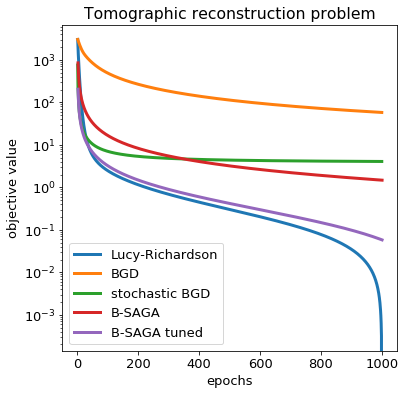

In [23]:
F_min = min([np.min(a) for a in [F_MU, F_BGD, F_BSGD, F_BSAGA, F_BSAGA_tuned]])

plt.plot(T_MU, F_MU - F_min, label = "Lucy-Richardson")
plt.plot(np.array(T_BGD), F_BGD - F_min, label = "BGD")
plt.plot(np.array(T_BSGD), F_BSGD - F_min, label = "stochastic BGD")
plt.plot(np.array(T_BSAGA), F_BSAGA - F_min, label = "B-SAGA")
plt.plot(np.array(T_BSAGA_tuned), F_BSAGA_tuned - F_min, label = "B-SAGA tuned")

plt.ylabel("objective value")
plt.xlabel("epochs")
plt.legend()
plt.title("Tomographic reconstruction problem")
plt.semilogy()

## Examining 

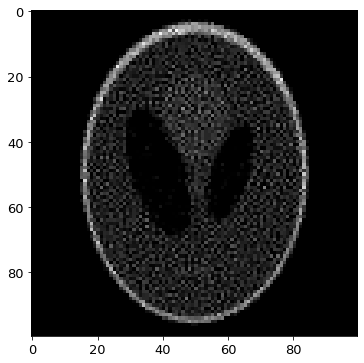

In [24]:
plt.imshow(X_BSGD, 'gray', vmin=0, vmax=16)

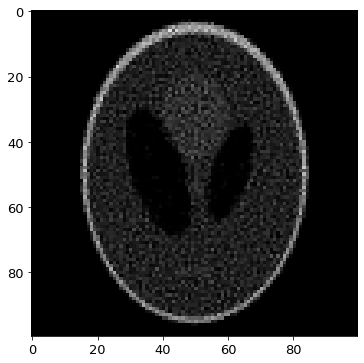

In [25]:
plt.imshow(X_MU, 'gray', vmin=0, vmax=16)